/tmp/ipykernel_2744539/1633852400.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


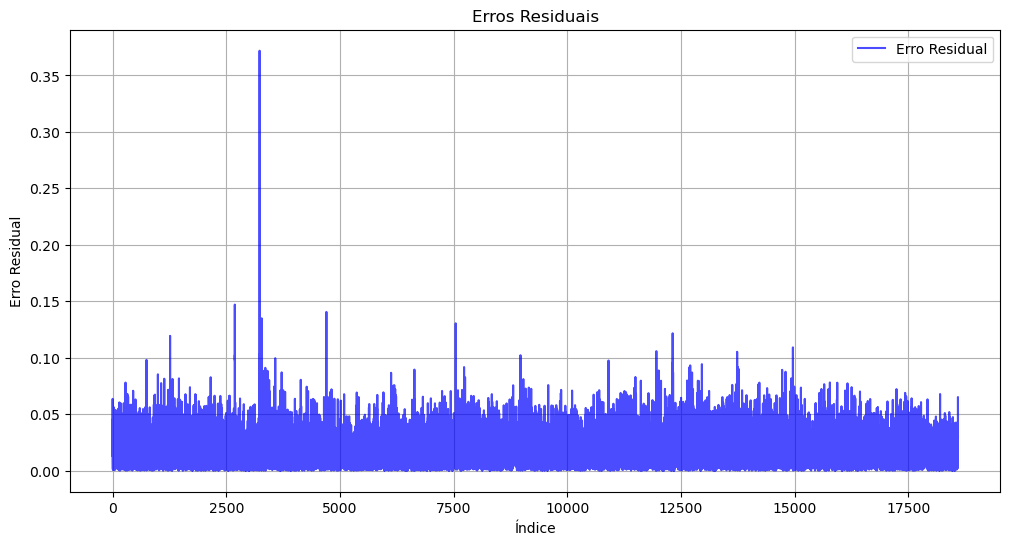

In [1]:
import os
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from river.drift import ADWIN, PageHinkley, KSWIN, DDM, HDDM_A, EDDM, HDDM_W
import matplotlib.pyplot as plt
import torch.nn as nn

class ImprovedLSTM(nn.Module):
    def __init__(self):
        super(ImprovedLSTM, self).__init__()
        
        self.hidden_size = 256
        self.num_layers = 3
        self.input_size = 10
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True
        )
        
        # Layer Normalization for LSTM output
        self.layer_norm_lstm = nn.LayerNorm(2 * self.hidden_size)  # Bidirectional LSTM output size
        
        # Fully connected layers
        self.fc1 = nn.Linear(2 * self.hidden_size, 256)
        self.layer_norm_fc1 = nn.LayerNorm(256)  # LayerNorm for fc1
        
        self.fc2 = nn.Linear(256, 128)
        self.layer_norm_fc2 = nn.LayerNorm(128)  # LayerNorm for fc2
        
        self.fc3 = nn.Linear(128, 64)
        self.layer_norm_fc3 = nn.LayerNorm(64)  # LayerNorm for fc3
        
        self.fc4 = nn.Linear(64, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Pass through LSTM
        lstm_output, _ = self.lstm(x)  # lstm_output: (batch_size, seq_length, 2 * hidden_size)
        
        # Take the output of the last time step
        lstm_output = lstm_output[:, -1, :]  # (batch_size, 2 * hidden_size)
        
        # Apply Layer Normalization to LSTM output
        lstm_output = self.layer_norm_lstm(lstm_output)
        
        # Fully connected layers with Layer Normalization, activation, and dropout
        x = self.fc1(lstm_output)
        x = self.layer_norm_fc1(x)  # LayerNorm for fc1
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.layer_norm_fc2(x)  # LayerNorm for fc2
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.layer_norm_fc3(x)  # LayerNorm for fc3
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        
        # Output layer
        out = self.sigmoid(x)  # Assuming binary classification or scaled output
        
        return out

# Inferência com Detectores de Drift
model_path = "cpu_model_best_rmse.pt"
model = torch.load(model_path)
model.eval()

data_path = "cpu_usage_1-13.xlsx"
dataset = pd.read_excel(data_path)

# Preparar os dados
X_columns = dataset.columns[:len(dataset.columns)-1]
X = np.array(dataset[X_columns])
y_real = np.array(dataset["y"])

# Transformar para tensor e realizar inferência
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy().flatten()

# Calcular erros residuais
errors = np.abs(y_real - y_pred)

# Visualizar os resultados
plt.figure(figsize=(12, 6))
plt.plot(errors, label="Erro Residual", color="blue", alpha=0.7)
plt.title("Erros Residuais")
plt.xlabel("Índice")
plt.ylabel("Erro Residual")
plt.legend()
plt.grid()
plt.show()


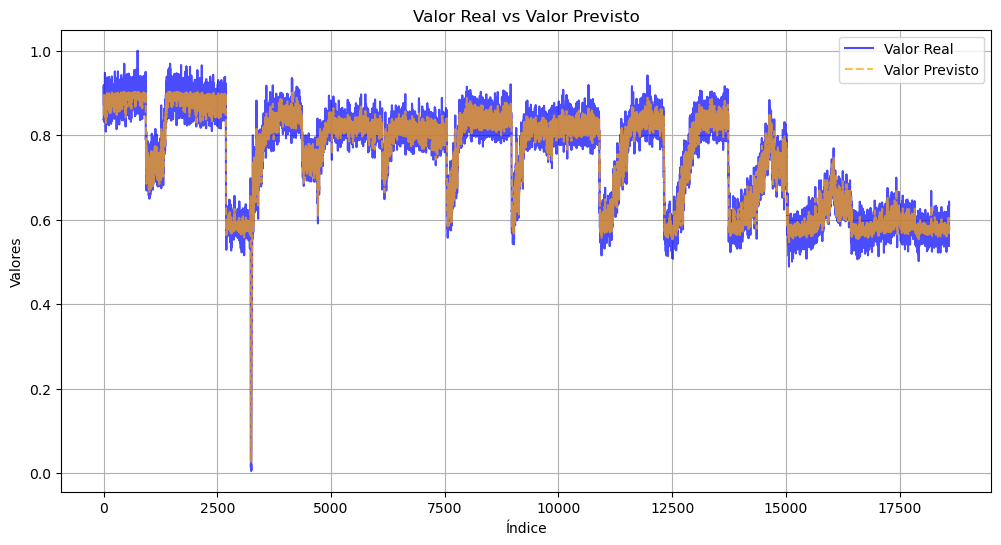

In [2]:
# Visualizar os resultados: Valor Real vs Valor Previsto
plt.figure(figsize=(12, 6))
plt.plot(y_real, label="Valor Real", color="blue", alpha=0.7)
plt.plot(y_pred, label="Valor Previsto", color="orange", alpha=0.7, linestyle="--")
plt.title("Valor Real vs Valor Previsto")
plt.xlabel("Índice")
plt.ylabel("Valores")
plt.legend()
plt.grid()
plt.show()


Aplicando detectores nos dados originais...
Calculando métricas para os dados originais...
Plotando resultados para os dados originais...


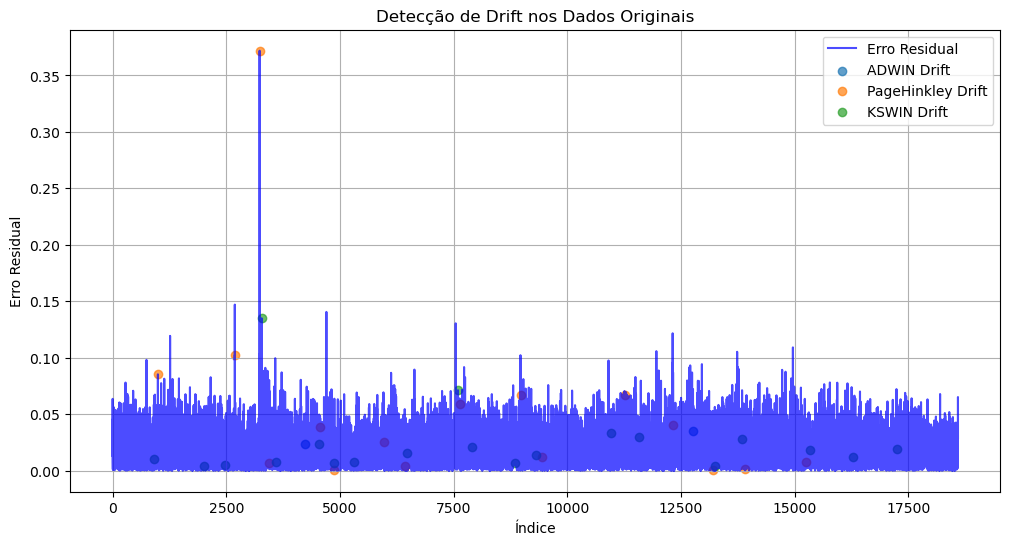

Índices detectados para os dados originais:
ADWIN: [4223, 12767]
PageHinkley: [997, 2690, 3233, 3432, 4569, 4867, 5973, 6438, 7636, 8975, 9445, 11277, 12333, 13213, 13904, 15243]
KSWIN: [918, 2017, 2476, 3279, 3587, 4545, 4861, 5317, 6476, 7595, 7902, 8851, 9313, 10950, 11566, 13257, 13850, 15330, 16279, 17256]

Métricas para os dados originais:
ADWIN: {'TP': 2, 'FP': 0, 'FN': 10, 'Precision': 1.0, 'Recall': 0.16666666666666666, 'F1-Score': 0.2857142857142857}
PageHinkley: {'TP': 7, 'FP': 8, 'FN': 5, 'Precision': 0.4666666666666667, 'Recall': 0.5833333333333334, 'F1-Score': 0.5185185185185186}
KSWIN: {'TP': 7, 'FP': 13, 'FN': 5, 'Precision': 0.35, 'Recall': 0.5833333333333334, 'F1-Score': 0.4375}


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from river.drift import ADWIN, PageHinkley, KSWIN

# Carregar os erros residuais calculados previamente
data_path = "erros_residuais.npy"
errors = np.load(data_path)

# Inicializar detectores de drift
detectors = {
    "ADWIN": ADWIN(delta=0.7),
    "PageHinkley": PageHinkley(delta=0.001, threshold=0.6, alpha=0.99),
    "KSWIN": KSWIN(alpha=0.002, window_size=300, stat_size=75)
}

# Número de amostras por dia
samples_per_day = 1430

# Cálculo dos drifts reais (transições entre dias)
total_samples = len(errors)
real_drifts = [i for i in range(samples_per_day, total_samples, samples_per_day)]

# Função para aplicar detectores
def apply_detectors(errors, detectors):
    drift_results = {name: [] for name in detectors}

    for i, error in enumerate(errors):
        for name, detector in detectors.items():
            detector.update(error)
            if detector.drift_detected:
                drift_results[name].append(i)

    return drift_results

# Aplicar detectores nos dados originais
print("Aplicando detectores nos dados originais...")
drift_original = apply_detectors(errors, detectors)

# Função para calcular métricas de avaliação
def evaluate_detectors(real_drifts, detected_drifts, tolerance=400):
    metrics = {}

    for name, detected in detected_drifts.items():
        tp = 0
        fp = 0
        fn = 0

        # True Positives: Detecções dentro da tolerância
        for real_drift in real_drifts:
            if any(abs(real_drift - d) <= tolerance for d in detected):
                tp += 1
            else:
                fn += 1

        # False Positives: Detecções fora da tolerância
        fp = len([d for d in detected if all(abs(d - real_drift) > tolerance for real_drift in real_drifts)])

        # Precision, Recall, F1-Score
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics[name] = {
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        }

    return metrics

# Avaliar detectores
print("Calculando métricas para os dados originais...")
metrics_original = evaluate_detectors(real_drifts, drift_original)

# Função para plotar resultados
def plot_results(errors, drift_results, title="Resultados de Detecção de Drift"):
    plt.figure(figsize=(12, 6))
    plt.plot(errors, label="Erro Residual", color="blue", alpha=0.7)

    for name, indices in drift_results.items():
        plt.scatter(indices, [errors[i] for i in indices], label=f"{name} Drift", alpha=0.7)

    plt.title(title)
    plt.xlabel("Índice")
    plt.ylabel("Erro Residual")
    plt.legend()
    plt.grid()
    plt.show()

# Plotar resultados
print("Plotando resultados para os dados originais...")
plot_results(errors, drift_original, title="Detecção de Drift nos Dados Originais")

# Exibir índices detectados
print("Índices detectados para os dados originais:")
for name, indices in drift_original.items():
    print(f"{name}: {indices}")

# Exibir métricas de avaliação
print("\nMétricas para os dados originais:")
for name, metrics in metrics_original.items():
    print(f"{name}: {metrics}")
